In [ ]:
import pandas as pd  # For data manipulation and analysis, including reading and handling datasets.
import seaborn as sns  # For statistical data visualization, useful for plotting correlation heatmaps and distribution plots.
import matplotlib.pyplot as plt  # For creating static, animated, and interactive visualizations.
from sklearn.impute import SimpleImputer  # For handling missing data by imputing missing values.
from sklearn.datasets import fetch_california_housing  # To fetch the California Housing dataset for regression tasks.
from sklearn.preprocessing import StandardScaler  # To standardize features by removing the mean and scaling to unit variance.
from sklearn.model_selection import train_test_split  # To split the dataset into training and testing subsets.
from sklearn.ensemble import RandomForestRegressor  # To build a regression model using an ensemble of decision trees.
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score  # To evaluate the regression model using RMSE, MAE, and R² metrics.
import numpy as np  # For numerical operations and handling multi-dimensional arrays.
from sklearn.model_selection import GridSearchCV  # For hyperparameter tuning using cross-validation to optimize the model.
import pickle  # To serialize and save the trained machine learning model for later use in deployment.
import joblib

## Part 1: Data Preprocessing

### a. Exploratory Data Analysis (EDA)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   MedInc       20640 non-null  float64
 1   HouseAge     20640 non-null  float64
 2   AveRooms     20640 non-null  float64
 3   AveBedrms    20640 non-null  float64
 4   Population   20640 non-null  float64
 5   AveOccup     20640 non-null  float64
 6   Latitude     20640 non-null  float64
 7   Longitude    20640 non-null  float64
 8   MedHouseVal  20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB
None
             MedInc      HouseAge      AveRooms     AveBedrms    Population  \
count  20640.000000  20640.000000  20640.000000  20640.000000  20640.000000   
mean       3.870671     28.639486      5.429000      1.096675   1425.476744   
std        1.899822     12.585558      2.474173      0.473911   1132.462122   
min        0.499900      1.000000      0.846154      0.333333      3.

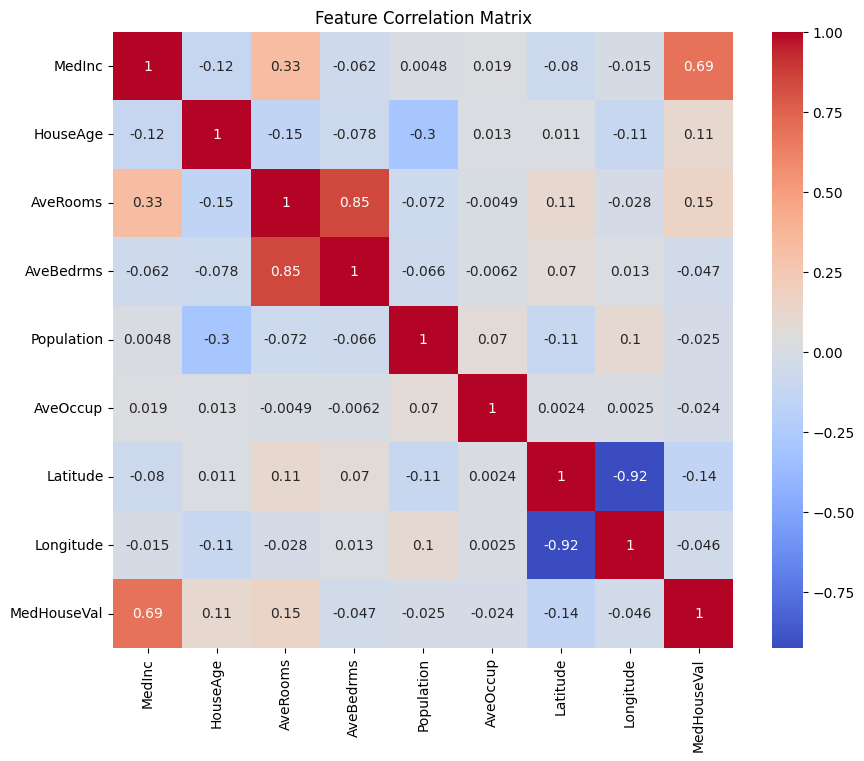

In [ ]:
# Load the California Housing dataset as a DataFrame
data = fetch_california_housing(as_frame=True)
df = data.frame  # Extract the DataFrame from the fetched data

# Rename the target column for clarity
df['MedHouseVal'] = df['MedHouseVal']

# Print a quick overview of the dataset's structure and data types
print(df.info())

# Print summary statistics of the dataset to understand its distribution and central tendencies
print(df.describe())

# Create a correlation heatmap to visualize the relationships between features and the target variable
plt.figure(figsize=(10, 8))  # Set the figure size for better visualization
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')  # Plot the heatmap with annotations and a coolwarm color palette
plt.title("Feature Correlation Matrix")  # Add a title to the heatmap
plt.show()  # Display the plot

### b. Handling Missing Values

In [ ]:
# Check for missing values
print(df.isnull().sum())
# imputation (if needed), however in our case it is not needed, as there are
# no missing values
#imputer = SimpleImputer(strategy='median')
#df[df.columns] = imputer.fit_transform(df)

MedInc         0
HouseAge       0
AveRooms       0
AveBedrms      0
Population     0
AveOccup       0
Latitude       0
Longitude      0
MedHouseVal    0
dtype: int64


### c. Feature Engineering

In [ ]:
# Initialize the StandardScaler for feature scaling
scaler = StandardScaler()

# Identify all numerical columns (int64 and float64 types) except the target variable 'MedHouseVal'
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns.drop('MedHouseVal')

# Apply the StandardScaler to the selected numerical features and update the DataFrame
# This standardizes the features by removing the mean and scaling to unit variance
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

## Part 2: Model Training & Evaluation

### a. Splitting the Data

In [ ]:
X = df.drop('MedHouseVal', axis=1)
y = df['MedHouseVal']
# Splitting the dataset into training and test sets using train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### b. Training a Regression Model

In [ ]:
# Initialize the Random Forest Regressor with a fixed random state for reproducibility
rf = RandomForestRegressor(random_state=42)

# Fit the model using the training data
rf.fit(X_train, y_train)

# Use the trained model to make predictions on the test set
y_pred = rf.predict(X_test)

# Calculate the Root Mean Squared Error (RMSE) to measure the average error magnitude
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# Calculate the Mean Absolute Error (MAE) to measure the average absolute difference between predictions and actual values
mae = mean_absolute_error(y_test, y_pred)

# Calculate the R-squared (R²) score to determine the proportion of variance in the target variable explained by the model
r2 = r2_score(y_test, y_pred)

# Print the evaluation metrics with formatting for clarity
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R²: {r2:.4f}")

RMSE: 0.5064
MAE: 0.3322
R²: 0.8047


### c. Hyperparameter Tuning

In [ ]:
# Define the hyperparameter grid to search over.
# 'n_estimators': Number of trees in the forest.
# 'max_depth': Maximum depth of each tree. 'None' means nodes are expanded until all leaves are pure.
# 'min_samples_split': Minimum number of samples required to split an internal node.
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
}

# Initialize GridSearchCV with RandomForestRegressor and the parameter grid.
# cv=5 specifies 5-fold cross-validation.
# scoring='neg_mean_squared_error' tells GridSearchCV to use negative MSE as the evaluation metric.
# n_jobs=-1 uses all available processors to speed up computation.
grid_search = GridSearchCV(RandomForestRegressor(random_state=42),
                           param_grid,
                           cv=5,
                           scoring='neg_mean_squared_error',
                           n_jobs=-1)

# Fit GridSearchCV to the training data to find the best hyperparameters.
grid_search.fit(X_train, y_train)

# Print the best hyperparameters found during the grid search.
print("Best parameters:", grid_search.best_params_)

# Retrieve the best estimator (RandomForestRegressor with the best parameters)
best_rf = grid_search.best_estimator_

# Use the best estimator to make predictions on the test set.
y_pred_best = best_rf.predict(X_test)

# Calculate the tuned model's RMSE to evaluate performance improvements.
rmse_best = np.sqrt(mean_squared_error(y_test, y_pred_best))
print(f"Tuned RMSE: {rmse_best:.4f}")

Best parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
Tuned RMSE: 0.5035


### d. Saving the Model

In [ ]:
# Saving the compressed trained model using joblib
joblib.dump(best_rf, 'house_price_model.pkl', compress=9)

['house_price_model.pkl']